In [1]:
# Imports de utilidades de Python
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import git
import os, sys

path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
os.chdir(os.path.join(path_git, 'utils'))
from functions import *

os.chdir(path_git)


2024-11-12 09:49:39.049929: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Los datos
Vamos a trabajar con los registros diarios de casos confirmados y tasa de positividad para el COVID-19 en Argentina. Lo que buscamos es ver cómo funciona la predicción de un segmento de datos faltantes. En principio, trataremos de lidiar con la periodicidad intrínseca que tienen los datos (7 días), aunque podremos también trabajar con una versión suavizada.

In [2]:
d = pd.read_csv(os.path.join(path_git, 'source', 'covidProcesado.csv'))
d.loc[:,'fecha_diagnostico'] = pd.to_datetime(d.fecha_diagnostico)
d = d.groupby(pd.Grouper(key = 'fecha_diagnostico', freq = '1D')).agg({'Confirmado' : sum,
                                                                      'tasa' : np.mean}).reset_index()
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849 entries, 0 to 848
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fecha_diagnostico  849 non-null    datetime64[ns]
 1   Confirmado         849 non-null    float64       
 2   tasa               849 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 20.0 KB


/home/tcicchini/anaconda3/envs/ml_env/lib/python3.9/site-packages/pandas/core/groupby/grouper.py:381: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  ax = Index(obj[key], name=key)
/tmp/ipykernel_36540/640307120.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  d = d.groupby(pd.Grouper(key = 'fecha_diagnostico', freq = '1D')).agg({'Confirmado' : sum,
/tmp/ipykernel_36540/640307120.py:3: FutureWarning: The provided callable <function mean at 0x7fd56049b040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
 

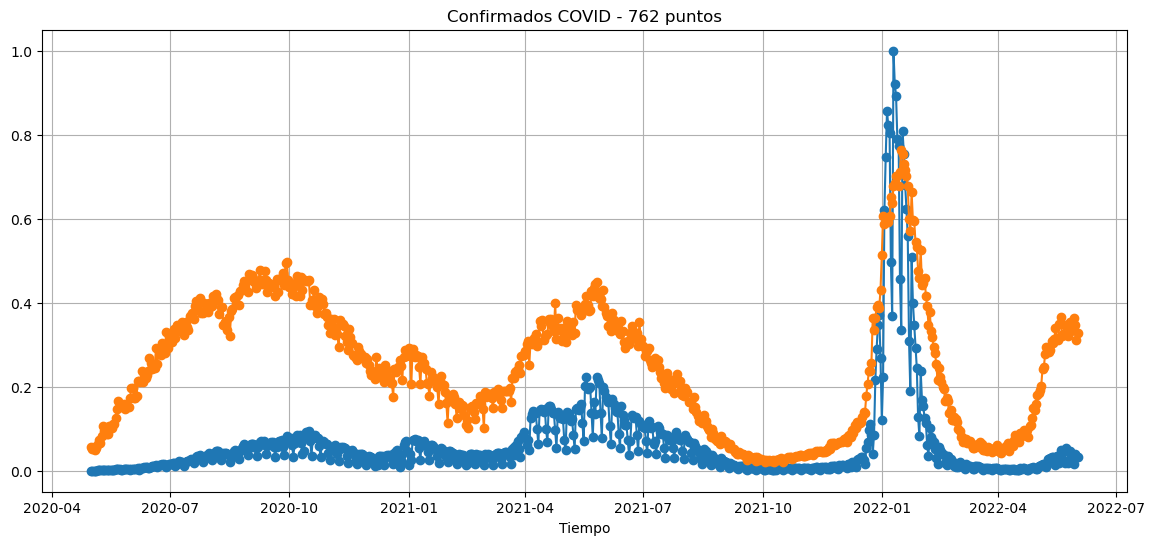

In [3]:
# Acortar la secuencia para que no sea tan larga y tenga una amplitud similar
fi = pd.to_datetime('2020-05-01') # fecha inicial
ff = pd.to_datetime('2022-06-01') # fecha final

raw_seq_alt = d[d.fecha_diagnostico.between(fi, ff)].tasa.to_numpy()
raw_seq = d[d.fecha_diagnostico.between(fi, ff)].Confirmado.to_numpy()
raw_seq = raw_seq / raw_seq.max()
t = d[d.fecha_diagnostico.between(fi, ff)].fecha_diagnostico.to_numpy()

# Graficar la señal temporal
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(t, raw_seq, '-o', label = 'confirmados (norm)')
ax.plot(t, raw_seq_alt, '-o', label = 'Tasa ')
ax.set_xlabel('Tiempo')
ax.set_title(f'Confirmados COVID - {len(t)} puntos')
ax.grid(True)
plt.show()

# El análisis preliminar
A modo de introducción, veamos un ejemplo de cómo podemos utilizar la metodología propuesta para analizar esta base de datos. Para esto, trabajamos únicamente con los datos de confirmados.

In [5]:
# Parámetros de la simulación

# choose a number of time steps
look_back = 14

# Cantidad de valores por cada paso temporal
n_features = 1

# Cantidad de pasos que queremos predecir hacia adelante
window_size = 100

# longitud de la cadena izquierda
len_left_chain = 320

# longitud de la cadena derecha
len_right_chain = 180

Tamaños de la secuencia izquierda: 320,320
Tamaños de la secuencia derecha: 180,180
Tamaños de la ventana: 100,100


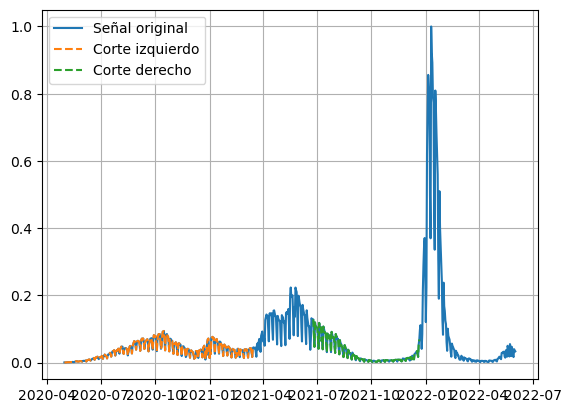

In [7]:
i_inicial = 0
raw_seq_1 = raw_seq[i_inicial:i_inicial+len_left_chain]
t_1 = t[i_inicial:i_inicial+len_left_chain]

print(f'Tamaños de la secuencia izquierda: {len(raw_seq_1)},{len_left_chain}')

raw_seq_2 = raw_seq[i_inicial+len_left_chain+window_size:i_inicial+len_left_chain+window_size + len_right_chain]
t_2 = t[i_inicial+len_left_chain+window_size:i_inicial+len_left_chain+window_size + len_right_chain]

raw_seq_2_bw = raw_seq_2[::-1]
t_2_bw = t_2[::-1]

print(f'Tamaños de la secuencia derecha: {len(raw_seq_2)},{len_right_chain}')

t_window = t[i_inicial+len_left_chain:i_inicial+len_left_chain+window_size]
raw_seq_window = raw_seq[i_inicial+len_left_chain:i_inicial+len_left_chain+window_size]
print(f'Tamaños de la ventana: {len(raw_seq_window)},{window_size}')

plt.plot(t,raw_seq, label='Señal original')
plt.plot(t_1,raw_seq_1, '--', label='Corte izquierdo')
plt.plot(t_2,raw_seq_2, '--', label='Corte derecho')
plt.grid()
plt.legend()
plt.show()

In [6]:
print('t_1 limits:',t_1[0],t_1[-1])
print('t_window limits:', t_window[0],t_window[-1])
print('t_2 limits:',t_2[0],t_2[-1])
print('t limits:',t[0],t[-1])
print('len of times:', len(t_1),len(t_window),len(t_2),len(t))

t_1 limits: 2020-05-01T00:00:00.000000000 2021-03-16T00:00:00.000000000
t_window limits: 2021-03-17T00:00:00.000000000 2021-06-24T00:00:00.000000000
t_2 limits: 2021-06-25T00:00:00.000000000 2021-12-21T00:00:00.000000000
t limits: 2020-05-01T00:00:00.000000000 2022-06-01T00:00:00.000000000
len of times: 320 100 180 762


In [7]:
predicciones_adelante_1,valores_reales_1 = make_predictions(raw_seq_1, look_back, n_features, raw_seq_window)
diferencia_1 = np.abs(predicciones_adelante_1-raw_seq_window)

predicciones_adelante_2_bw,valores_reales_2_bw = make_predictions(raw_seq_2_bw, look_back, n_features, raw_seq_window[::-1])
predicciones_adelante_2 = predicciones_adelante_2_bw[::-1]
valores_reales_2 = valores_reales_2_bw[::-1]

diferencia_2 = np.abs(predicciones_adelante_2-raw_seq_window)

2024-11-12 09:04:45.288636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 0s 17ms/step


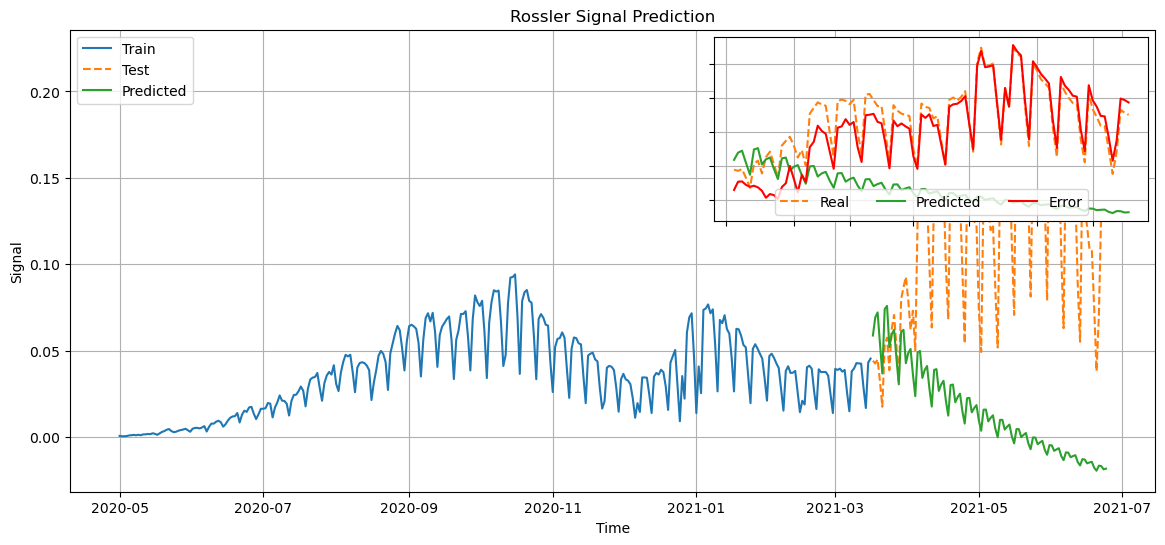

In [8]:
fig, ax = plt.subplots(figsize = (14,6))
ax.plot(t_1,raw_seq_1,label='Train')
ax.plot(t_window,raw_seq_window,'--',label='Test')
ax.plot(t_window,predicciones_adelante_1,label='Predicted')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Signal')
ax.set_title('Rossler Signal Prediction')
ax.legend(loc = 'upper left')

axin = inset_axes(ax, width = "40%", height = "40%", loc = 'upper right')

axin.plot(t_window,raw_seq_window, '--',label = 'Real', color = 'C1')
axin.plot(t_window,predicciones_adelante_1, label = 'Predicted', color = 'C2')
axin.plot(t_window,diferencia_1, label = 'Error', color = 'red')
axin.set_xticklabels([])
axin.set_yticklabels([])
axin.grid(True)
axin.legend(ncol = 3, loc = 'lower center')


plt.show()

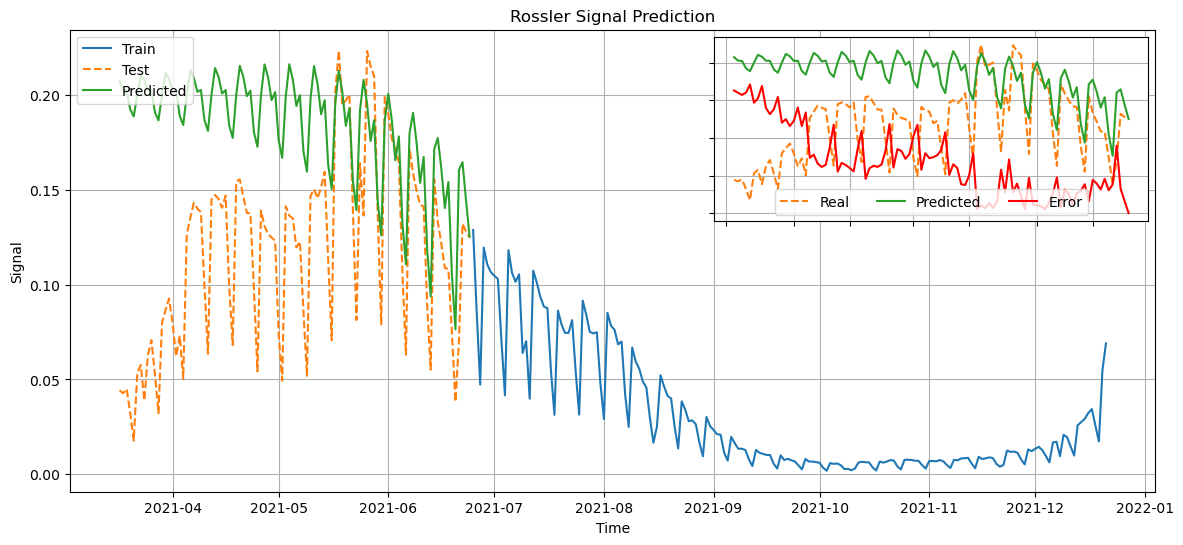

In [9]:
fig, ax = plt.subplots(figsize = (14,6))
ax.plot(t_2,raw_seq_2,label='Train')
ax.plot(t_window,raw_seq_window,'--',label='Test')
ax.plot(t_window,predicciones_adelante_2,label='Predicted')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Signal')
ax.set_title('Rossler Signal Prediction')
ax.legend(loc = 'upper left')

axin = inset_axes(ax, width = "40%", height = "40%", loc = 'upper right')

axin.plot(t_window,raw_seq_window, '--',label = 'Real', color = 'C1')
axin.plot(t_window,predicciones_adelante_2, label = 'Predicted', color = 'C2')
axin.plot(t_window,diferencia_2, label = 'Error', color = 'red')
axin.set_xticklabels([])
axin.set_yticklabels([])
axin.grid(True)
axin.legend(ncol = 3, loc = 'lower center')


plt.show()


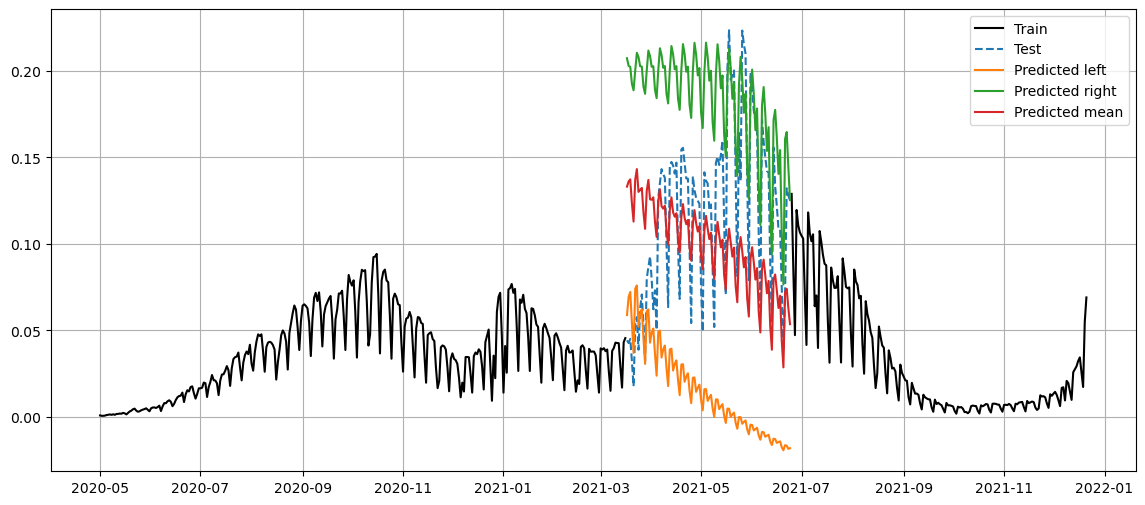

In [10]:
prediction_mean = (predicciones_adelante_1 + predicciones_adelante_2)/2


fig, ax = plt.subplots(figsize = (14,6))
ax.plot(t_1,raw_seq_1,'k',label='Train')
ax.plot(t_window,valores_reales_1,'--',label='Test')
ax.plot(t_window,predicciones_adelante_1,label='Predicted left')
ax.plot(t_2,raw_seq_2,'k')
ax.plot(t_window,predicciones_adelante_2,label='Predicted right')
ax.plot(t_window,prediction_mean,label='Predicted mean')
ax.grid()
ax.legend()
plt.show()

# Jugando un poco más
Hasta ahora, sólo trabajamos con un modelo de la siguiente pinta:
```
model = Sequential()
model.add(SimpleRNN(20, activation='tanh', input_shape=(look_back, n_features)))
model.add(Dense(1,activation='linear'))
model.compile(optimizer='adam', loss='mse')
```

Ahora bien, teniendo en cuenta que en este caso tenemos dos dinámicas temporales (una asociada a la periodicidad semanal y otra a la del avance de la enfermedad), podríamos tratar de utilizar una capa LSTM en cambio de la RNN para poder captar esta variación.

In [8]:
model = Sequential()
model.add(LSTM(30, activation='tanh',input_shape=(look_back, n_features)))
model.add(Dense(1, activation = 'relu'))
model.compile(optimizer='adam', loss='mse')


predicciones_adelante_1,valores_reales_1 = make_predictions(raw_seq_1, look_back, n_features, raw_seq_window, model = model)
diferencia_1 = np.abs(predicciones_adelante_1-raw_seq_window)

predicciones_adelante_2_bw,valores_reales_2_bw = make_predictions(raw_seq_2_bw, look_back, n_features, raw_seq_window[::-1], model = model)
predicciones_adelante_2 = predicciones_adelante_2_bw[::-1]
valores_reales_2 = valores_reales_2_bw[::-1]

diferencia_2 = np.abs(predicciones_adelante_2-raw_seq_window)

INFO:tensorflow:Assets written to: ram://951b3e3d-a065-44d8-8cf0-d62decba8f7f/assets


INFO:tensorflow:Assets written to: ram://951b3e3d-a065-44d8-8cf0-d62decba8f7f/assets


1/1 [==============================] - 0s 18ms/step


INFO:tensorflow:Assets written to: ram://05beb3c2-c810-4765-aaee-1ae29efabb42/assets


INFO:tensorflow:Assets written to: ram://05beb3c2-c810-4765-aaee-1ae29efabb42/assets


1/1 [==============================] - 0s 17ms/step


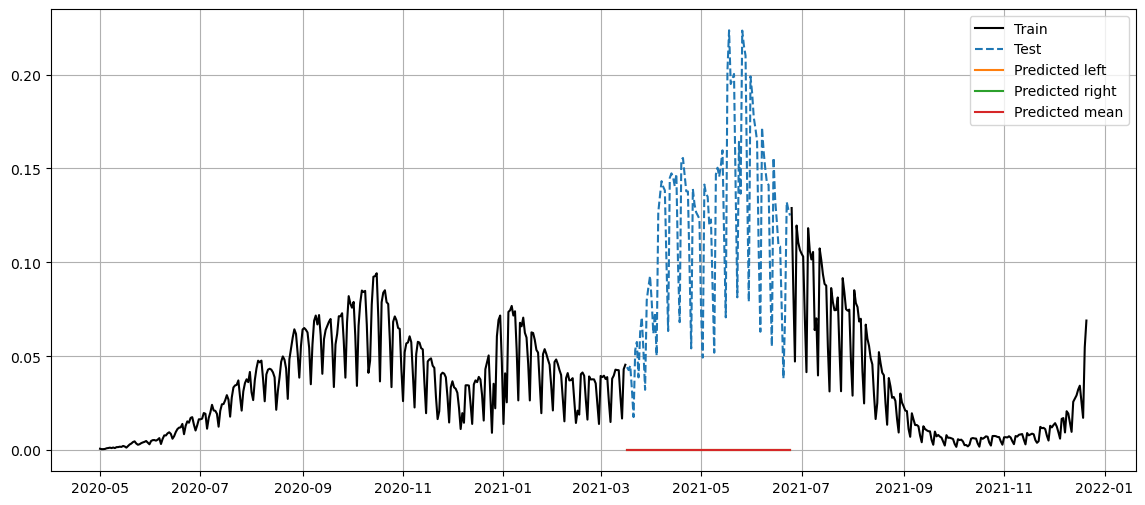

In [9]:
prediction_mean = (predicciones_adelante_1 + predicciones_adelante_2)/2


fig, ax = plt.subplots(figsize = (14,6))
ax.plot(t_1,raw_seq_1,'k',label='Train')
ax.plot(t_window,valores_reales_1,'--',label='Test')
ax.plot(t_window,predicciones_adelante_1,label='Predicted left')
ax.plot(t_2,raw_seq_2,'k')
ax.plot(t_window,predicciones_adelante_2,label='Predicted right')
ax.plot(t_window,prediction_mean,label='Predicted mean')
ax.grid()
ax.legend()
plt.show()

# Análisis sistemático
En vez de ir probando, sistematicemos un poco la comparación para distintos sets de parámetros y valores de las ventanas y datos.

In [ ]:
look_back = 14

n_features = 1

window_size = 100

len_left_chain = 320

len_right_chain = 180

i_inicial = 0
raw_seq_1 = raw_seq[i_inicial:i_inicial+len_left_chain]
t_1 = t[i_inicial:i_inicial+len_left_chain]

raw_seq_2 = raw_seq[i_inicial+len_left_chain+window_size:i_inicial+len_left_chain+window_size + len_right_chain]
t_2 = t[i_inicial+len_left_chain+window_size:i_inicial+len_left_chain+window_size + len_right_chain]

raw_seq_2_bw = raw_seq_2[::-1]
t_2_bw = t_2[::-1]

t_window = t[i_inicial+len_left_chain:i_inicial+len_left_chain+window_size]
raw_seq_window = raw_seq[i_inicial+len_left_chain:i_inicial+len_left_chain+window_size]

model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(look_back, n_features)),
    Bidirectional(LSTM(32)),
    Dense(1, activation = 'relu')])
model.compile(optimizer='adam', loss='mse')


predicciones_adelante_1,valores_reales_1 = make_predictions(raw_seq_1, look_back, n_features, raw_seq_window, model = model)
diferencia_1 = np.abs(predicciones_adelante_1-raw_seq_window)

predicciones_adelante_2_bw,valores_reales_2_bw = make_predictions(raw_seq_2_bw, look_back, n_features, raw_seq_window[::-1], model = model)
predicciones_adelante_2 = predicciones_adelante_2_bw[::-1]
valores_reales_2 = valores_reales_2_bw[::-1]

diferencia_2 = np.abs(predicciones_adelante_2-raw_seq_window)

INFO:tensorflow:Assets written to: ram://f6f98305-f62f-4532-92b8-76fcb56c3f32/assets


INFO:tensorflow:Assets written to: ram://f6f98305-f62f-4532-92b8-76fcb56c3f32/assets


1/1 [==============================] - 0s 44ms/step


INFO:tensorflow:Assets written to: ram://2d78e962-7d27-4b29-bf53-1512e0bbd664/assets


INFO:tensorflow:Assets written to: ram://2d78e962-7d27-4b29-bf53-1512e0bbd664/assets
